<a href="https://colab.research.google.com/github/GuilleGriffa/Principal/blob/master/Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Segmentación 

In [0]:
!pip install itk

In [0]:
!pip install SimpleITK

In [0]:
#Define algunas funciones útiles
from matplotlib import pyplot as plt
import itk
import numpy as np
from PIL import Image
import SimpleITK as sitk

In [0]:
#Bajar una imagen de prueba 
!wget -O /content/CT_cabeza_2D.png https://drive.google.com/uc?id=0B41zQP7VtCAyTk1CTjRBNnVyT3c

##Usos de la Sementación 

La segmentación de imágenes es el proceso de clasificar pixeles en grupos que corresponden al mismo tipo de tejido. 

* Medir el volumen de un órgano
* Mostrar (render) un modelo tridimensional de un órgano
* Registrar por medio de la superficie

##Umbralizado 

Es el método más simple de clasificación de pixeles y está basado solamente en sus **valores de intensidad**. Para umbralizar se elige una cota superior y una inferior y se seleccionan los pixeles con intensidades en dicho rango.

Por ejemplo, segmentamos el hueso en el siguiente corte de TC:

##Con ITK

In [0]:
def showITKImage(image, mode='L', ax=None):
  if ax:
    ax.imshow(Image.fromarray(itk.GetArrayFromImage(image), mode), cmap='gray')
  else:
    plt.imshow(Image.fromarray(itk.GetArrayFromImage(image), mode), cmap='gray')

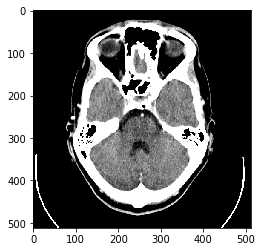

In [21]:
image_itk = itk.imread('/content/CT_cabeza_2D.png')
showITKImage(image_itk)

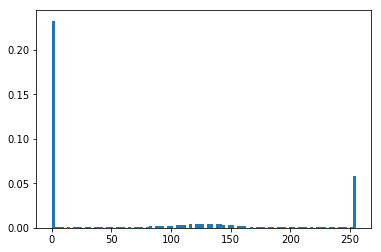

In [22]:
plt.hist(itk.GetArrayFromImage(image_itk).ravel(), bins=100, density=True)
plt.show()
#print(itk.GetArrayFromImage(image)[50:70,80:100]) #muestra una porcion de la matriz de la image

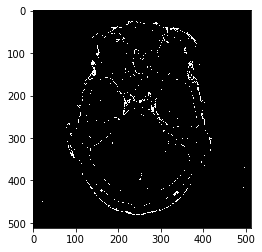

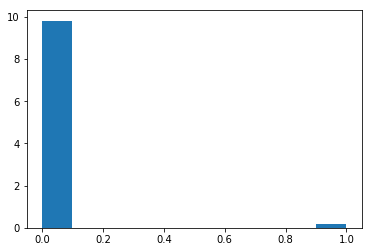

In [65]:
PixelType = itk.UC
Dimension = 2
ImageType = itk.Image[PixelType, Dimension]

thresholdFilter = itk.BinaryThresholdImageFilter[ImageType, ImageType].New()
thresholdFilter.SetInput(image_itk)
thresholdFilter.SetLowerThreshold(190)
thresholdFilter.SetUpperThreshold(240)
thresholdFilter.SetOutsideValue(0)
thresholdFilter.SetInsideValue(1)

thresholdFilter.Update()

plt.figure(0)
showITKImage(thresholdFilter.GetOutput())

thresholdFilter2 = itk.BinaryThresholdImageFilter[ImageType, ImageType].New()
thresholdFilter2.SetInput(thresholdFilter.GetOutput())

plt.figure(1)
plt.hist(itk.GetArrayFromImage(thresholdFilter.GetOutput()).ravel(), bins=10, density=True)
plt.show()

##Con SimpleITK

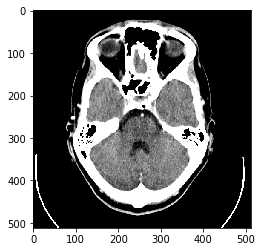

In [25]:
image_sitk = sitk.ReadImage('/content/CT_cabeza_2D.png')
plt.imshow(sitk.GetArrayViewFromImage(image_sitk),cmap='gray') #convertir en vector antes de poder graficar 
#plt.axis('off'); #Para que no aparezcan los ejes de la imagen

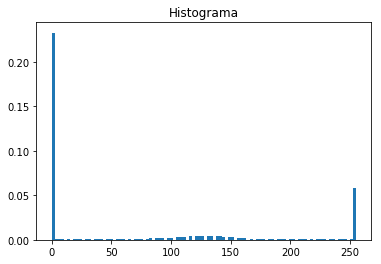

In [69]:
plt.hist(sitk.GetArrayFromImage(image_sitk).ravel(), bins=100, density=True) #bins indica el numero de divisiones 
plt.title("Histograma")
plt.show()

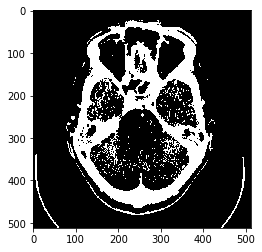

In [32]:
Seg_sitk = image_sitk > 150 #pixel vale 1 si su nivel de gris es mayor a 150
plt.imshow(sitk.GetArrayViewFromImage(Seg_sitk),cmap='gray')

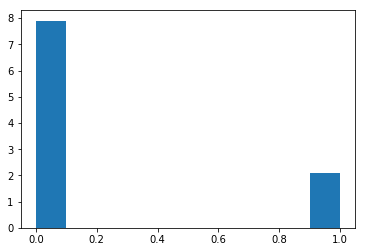

In [70]:
plt.hist(sitk.GetArrayFromImage(Seg_sitk).ravel(), bins=10, density=True)
plt.show()

Text(0.5, 1.0, 'Basic Thresholding')

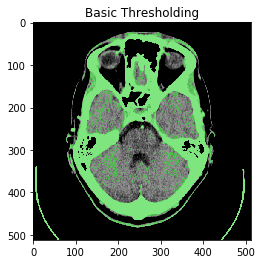

In [60]:
Superp_1 = sitk.LabelOverlay(image_sitk, Seg_sitk) #función para superponer imagen segmentada con original 
plt.imshow(sitk.GetArrayViewFromImage(Superp_1),cmap='gray')
plt.title('Basic Thresholding')

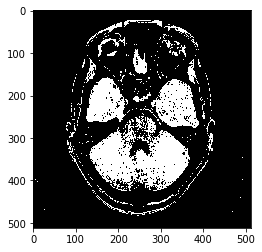

In [59]:
#Forma de binarizar indicando límite máximo y mínimo 
Seg_sitk_2 = sitk.BinaryThreshold(image_sitk, lowerThreshold=100, upperThreshold=200, insideValue=1, outsideValue=0)
plt.imshow(sitk.GetArrayViewFromImage(Seg_sitk_2),cmap='gray')

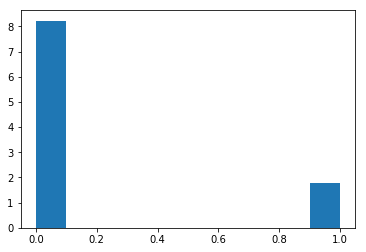

In [71]:
plt.hist(sitk.GetArrayFromImage(Seg_sitk_2).ravel(), bins=10, density=True)
plt.show()

Text(0.5, 1.0, 'Binary Thresholding')

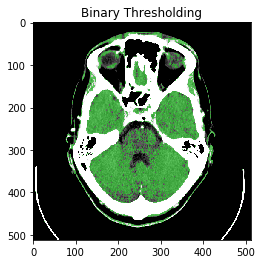

In [61]:
Superp_2 = sitk.LabelOverlay(image_sitk, Seg_sitk_2)
plt.imshow(sitk.GetArrayViewFromImage(Superp_2),cmap='gray')
plt.title('Binary Thresholding')

##Umbralizado de Otsu

Ya que el problema de la umbralización reside en la determinación del valor umbral que segmenta la imagen. El método de Otsu es uno de los más utilizados en la determinación automática de ese umbral. 
Este método proporciona el umbral óptimo ("threshold") para la segmentación de la imagen, bajo el criterio de máxima varianza entre fondo ("background") y objeto ("foreground").

##Con ITK

In [0]:
thresholdFilter = itk.OtsuMultipleThresholdsImageFilter[ImageType, ImageType].New()
thresholdFilter.SetInput(image)
thresholdFilter.SetNumberOfHistogramBins(256)
thresholdFilter.SetNumberOfThresholds(8)
thresholdFilter.SetLabelOffset(0)

rescaler = itk.RescaleIntensityImageFilter[ImageType, ImageType].New()
rescaler.SetInput(thresholdFilter.GetOutput())
rescaler.SetOutputMinimum(0)
rescaler.SetOutputMaximum(255)

plt.figure(0)
showITKImage(rescaler.GetOutput())

plt.figure(1)
thresholds = thresholdFilter.GetThresholds()

plt.hist(itk.GetArrayFromImage(image).ravel(), bins=100, density=True)
plt.axvline(x=thresholds[0], color='r', linestyle='dashed', linewidth=2)
plt.show()

##Con simpleITK

Text(0.5, 1.0, 'Otsu Thresholding')

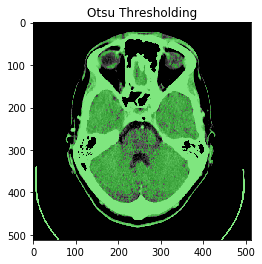

In [73]:
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)
otsu_filter.SetOutsideValue(1)
Seg_Otsu = otsu_filter.Execute(image_sitk)
plt.imshow(sitk.GetArrayViewFromImage(sitk.LabelOverlay(image_sitk, Seg_Otsu)), cmap='gray')
plt.title("Otsu Thresholding")

El umbral óptimo para separar frente de fondo es:

In [74]:
print(otsu_filter.GetThreshold() )

98.0


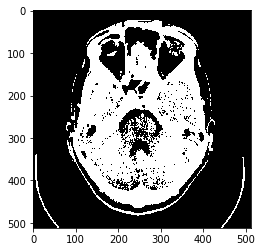

In [75]:
plt.imshow(sitk.GetArrayViewFromImage(Seg_Otsu), cmap='gray')

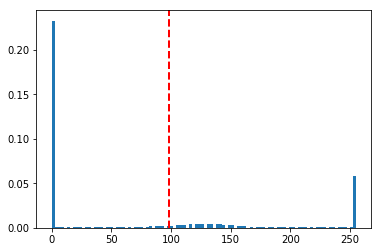

In [76]:
plt.hist(sitk.GetArrayFromImage(image_sitk).ravel(), bins=100, density=True)
plt.axvline(x=otsu_filter.GetThreshold(), color='r', linestyle='dashed', linewidth=2)
plt.show()